# Implementado un Perceptrón multi-capa usando frameworks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_1/notebooks/Nb_1b_Implementando_un_Percentron_Multiplicapa_MLP_usando_frameworks.ipynb)

In [29]:
#@title Importar librerías
#importar librerías necesarias
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import set_config
set_config(display='diagram')
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

In [2]:
#@title Funciones complementarias
def plot_samples_dataset(X, y):
    # Convertir las etiquetas a enteros
    y = y.astype(int)

    # Crear la grilla de 4x4
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    fig.suptitle('Grilla de imágenes del dataset MNIST')

    # Iterar para mostrar las primeras 16 imágenes con sus etiquetas
    for i, ax in enumerate(axes.flat):
        img = X.iloc[i].values.reshape(28, 28)
        label = y[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.show()

def plot_curva_aprendizaje(mlp):
    plt.figure(figsize=(8, 5))
    plt.plot(mlp.loss_curve_, marker='o')
    plt.title('Pérdida durante el entrenamiento del MLP por iteración')
    plt.xlabel('Iteración')
    plt.ylabel('Pérdida (Loss)')
    plt.grid()
    plt.show()

def plot_matriz_confusion(cm):
    # Visualizar la matriz de confusión usando Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title('Matriz de Confusión para el MLP en el dataset MNIST')
    plt.show()

def encontrar_dim_imagen(n_neurons):
    """
    Encuentra la mejor forma cuadrada (filas, columnas) para una cantidad dada de neuronas.
    """
    side_length = int(np.sqrt(n_neurons))  # Calcular la raíz cuadrada del número de neuronas
    if side_length * side_length == n_neurons:
        return (side_length, side_length)  # Si es un cuadrado perfecto
    else:
        # Si no es un cuadrado perfecto, buscamos la mejor aproximación (filas, columnas)
        for i in range(side_length, 0, -1):
            if n_neurons % i == 0:
                return (i, n_neurons // i)  # Devolver filas y columnas
    return (n_neurons, 1)  # Si no encuentra, retornar en forma de vector (n_neurons, 1)

def visualizacion_pesos_mlp(mlp):
    # Definir la figura con 3 filas y 5 columnas
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    # Asignar las dimensiones para visualizar cada capa
    layer_shapes = [encontrar_dim_imagen(layer.shape[0]) for layer in mlp.coefs_]

    # Recorrer cada capa de coeficientes del MLP
    for layer_index, (layer_coefs, ax_row) in enumerate(zip(mlp.coefs_, axes)):
        # Seleccionar aleatoriamente 5 neuronas de la capa actual
        num_neurons = layer_coefs.shape[1]
        random_neurons = random.sample(range(num_neurons), 5)

        # Obtener la forma de visualización para esta capa
        layer_shape = layer_shapes[layer_index]

        vmin, vmax = layer_coefs.min(), layer_coefs.max()

        # Visualizar las neuronas seleccionadas
        for neuron_index, ax in zip(random_neurons, ax_row):
            # Seleccionar los pesos de la neurona específica y reestructurarlos en una matriz 2D
            neuron_weights = layer_coefs[:, neuron_index].reshape(layer_shape)
            # Dibujar la imagen de los pesos de la neurona
            ax.matshow(neuron_weights, cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Capa {layer_index+1}, Neurona {neuron_index}')

    plt.suptitle('Visualización de Pesos de las Neuronas en las Capas Ocultas')
    plt.tight_layout()
    plt.show()

def plot_loss_historia_keras(history):
    # Graficar el histórico de pérdida durante el entrenamiento
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

def plot_acc_historia_keras(history):
    # Graficar la precisión durante el entrenamiento
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

def visualizacion_pesos_mlp_keras(model):
    # Obtener los pesos del modelo (par de listas [pesos, biases] para cada capa)
    weights = model.get_weights()

    # Extraer solo los pesos de cada capa oculta, ignorando los bias
    layer_weights = [weights[i] for i in range(0, len(weights), 2)]  # Solo los pesos, no los sesgos

    # Definir la figura con 3 filas (una por cada capa) y 5 columnas (5 neuronas al azar)
    fig, axes = plt.subplots(len(layer_weights), 5, figsize=(15, 9))

    # Calcular las formas de cada capa de manera dinámica
    layer_shapes = [encontrar_dim_imagen(layer.shape[0]) for layer in layer_weights]

    # Recorrer cada capa y sus pesos
    for layer_index, (layer_coefs, ax_row) in enumerate(zip(layer_weights, axes)):
        # Seleccionar aleatoriamente 5 neuronas de la capa actual
        num_neurons = layer_coefs.shape[1]
        random_neurons = random.sample(range(num_neurons), 5)

        # Obtener la forma de visualización para esta capa
        layer_shape = layer_shapes[layer_index]
        vmin, vmax = layer_coefs.min(), layer_coefs.max()


        # Visualizar las neuronas seleccionadas
        for neuron_index, ax in zip(random_neurons, ax_row):
            # Seleccionar los pesos de la neurona específica y reestructurarlos en una matriz 2D
            neuron_weights = layer_coefs[:, neuron_index].reshape(layer_shape)
            # Dibujar la imagen de los pesos de la neurona
            ax.matshow(neuron_weights, cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Capa {layer_index+1}, Neurona {neuron_index}')

    plt.suptitle('Visualización de Pesos de las Neuronas en las Capas Ocultas de Keras')
    plt.tight_layout()
    plt.show()

# Dataset MNIST (Clasificación multiclase)

Trabajaremos con el clásico dataset de imágenes de digitos escritos a mano. Esta dataset puede ser descargado de diversas fuentes incluido sklearn.

In [3]:
# Cargar el dataset de MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

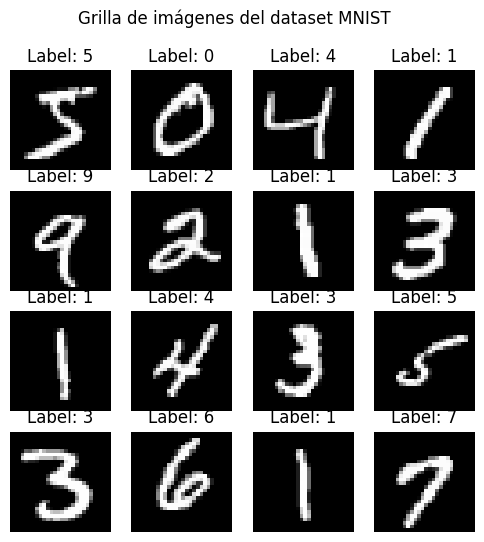

In [4]:
# Visualizamos algunas imágenes
plot_samples_dataset(X, y)

Un breve vistazo del dataset nos indica que la mayoría de pixeles de la imágen estan en 0 y que los que tiene valor estan en 255. Esta escala, es los valores de intensidad en escala de grises. Además, vemos que la información esta organizada en un dataframe con 784 columnas lo que se traduce en una versión vectorizada de una imágen de 28x28 píxeles.

In [5]:
X.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


Antes de hacer la división del conjunto de datos, podemos hacer una normalización de los valores de los píxeles para que esten entre 0-1, así es más fácil para la red optimizar la función de pérdida.

In [6]:
# Normalización
X = X / 255.

In [7]:
# usar train test split para dividir los datos X y y
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,  random_state=42)

print('Dimensión X_train: {}'.format(X_train.shape))
print('Dimensión X_test: {}'.format(X_test.shape))

Dimensión X_train: (49000, 784)
Dimensión X_test: (21000, 784)


# MLP clasificador multiclase en Sklearn

Seguidamente, vamos a crear un clasificador MLP usando la librería sklearn, pueden encontrar toda la documentación en: [Documentación MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [30]:
mlp = MLPClassifier(hidden_layer_sizes=(225, 100), activation = 'relu',
                    max_iter=30, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate = 'adaptive',
                    learning_rate_init = 0.1,
                    early_stopping=False, validation_fraction=0.2)

mlp

MLPClassifier(hidden_layer_sizes=(225, 100), learning_rate='adaptive',
              learning_rate_init=0.1, max_iter=30, random_state=1, solver='sgd',
              validation_fraction=0.2, verbose=10)

In [9]:
# Entrenar el clasificador MLP en los datos de entrenamiento
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.29809553
Iteration 2, loss = 0.10153217
Iteration 3, loss = 0.07025477
Iteration 4, loss = 0.05107289
Iteration 5, loss = 0.03813628
Iteration 6, loss = 0.02863240
Iteration 7, loss = 0.02136907
Iteration 8, loss = 0.01639116
Iteration 9, loss = 0.01391393
Iteration 10, loss = 0.00862180
Iteration 11, loss = 0.00514989
Iteration 12, loss = 0.00551735
Iteration 13, loss = 0.00416624
Iteration 14, loss = 0.00174071
Iteration 15, loss = 0.00094037
Iteration 16, loss = 0.00082533
Iteration 17, loss = 0.00067903
Iteration 18, loss = 0.00057994
Iteration 19, loss = 0.00053067
Iteration 20, loss = 0.00050842
Iteration 21, loss = 0.00048905
Iteration 22, loss = 0.00047281
Iteration 23, loss = 0.00045934
Iteration 24, loss = 0.00044890
Iteration 25, loss = 0.00043982
Iteration 26, loss = 0.00042988
Iteration 27, loss = 0.00042256
Iteration 28, loss = 0.00041607
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.020000

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(225, 100), learning_rate='adaptive',
              learning_rate_init=0.1, max_iter=30, random_state=1, solver='sgd',
              validation_fraction=0.2, verbose=10)

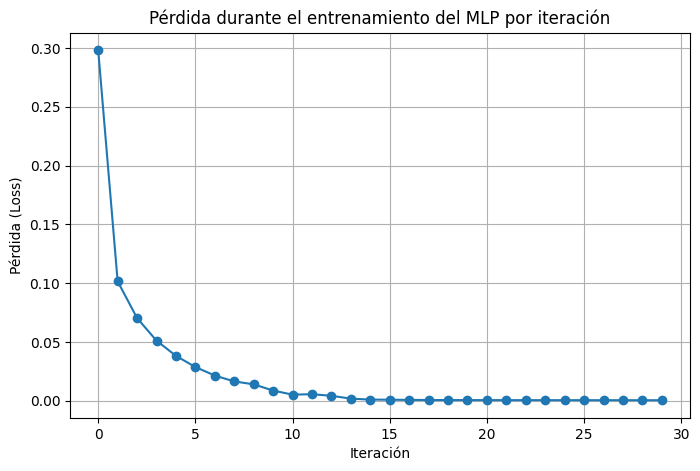

In [10]:
# imprimir la curva de evolución de la pérdida
plot_curva_aprendizaje(mlp)

## Evaluación completa

Realizaremos una evaluación completa revisando el rendimiento en ambos conjuntos, seguidamente generaremos el reporte de clasificación y la matriz de confusión.

In [11]:
print(f"Training set score: {mlp.score(X_train, y_train):.3f}")
print(f"Test set score: {mlp.score(X_test, y_test):.3f}")

Training set score: 1.000
Test set score: 0.982


Reporte de Clasificación del MLP en MNIST:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2058
           1       0.99      0.99      0.99      2364
           2       0.98      0.98      0.98      2133
           3       0.98      0.98      0.98      2176
           4       0.98      0.98      0.98      1936
           5       0.98      0.98      0.98      1915
           6       0.98      0.99      0.99      2088
           7       0.98      0.98      0.98      2248
           8       0.98      0.97      0.97      1992
           9       0.98      0.97      0.98      2090

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



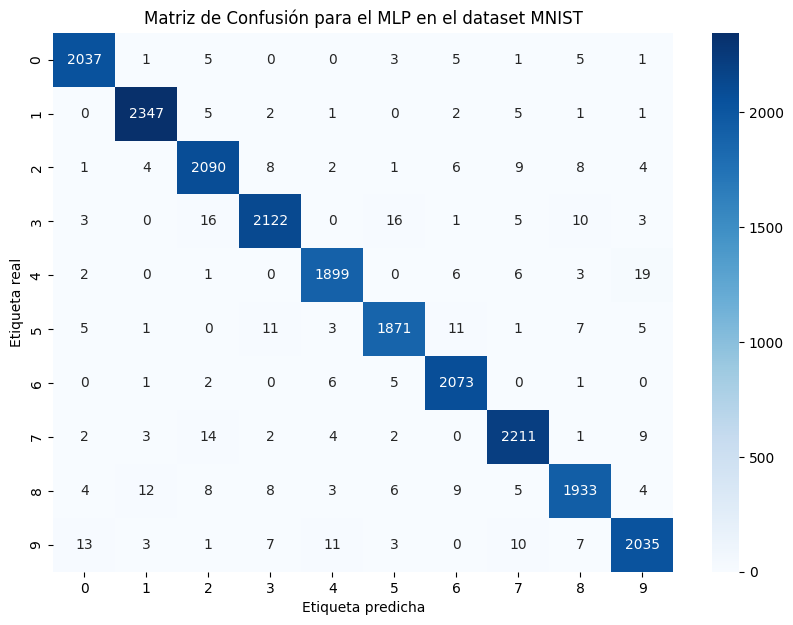

In [12]:
# Realizar predicciones
y_pred = mlp.predict(X_test)

# Imprimir el reporte de métricas
print("Reporte de Clasificación del MLP en MNIST:\n")
print(classification_report(y_test, y_pred))

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# visualizar la matriz de confusión
plot_matriz_confusion(cm)

## Visualización de pesos

In [13]:
# pesos de la primera capa oculta. Todas las neuronas conectadas con cada pixel
print('Dimensión de la primera capa oculta: {}'.format(mlp.coefs_[0].shape))
print('Dimensión de la segunda capa oculta: {}'.format(mlp.coefs_[1].shape))
print('Dimensión de la tercera capa oculta: {}'.format(mlp.coefs_[2].shape))

Dimensión de la primera capa oculta: (784, 225)
Dimensión de la segunda capa oculta: (225, 100)
Dimensión de la tercera capa oculta: (100, 10)


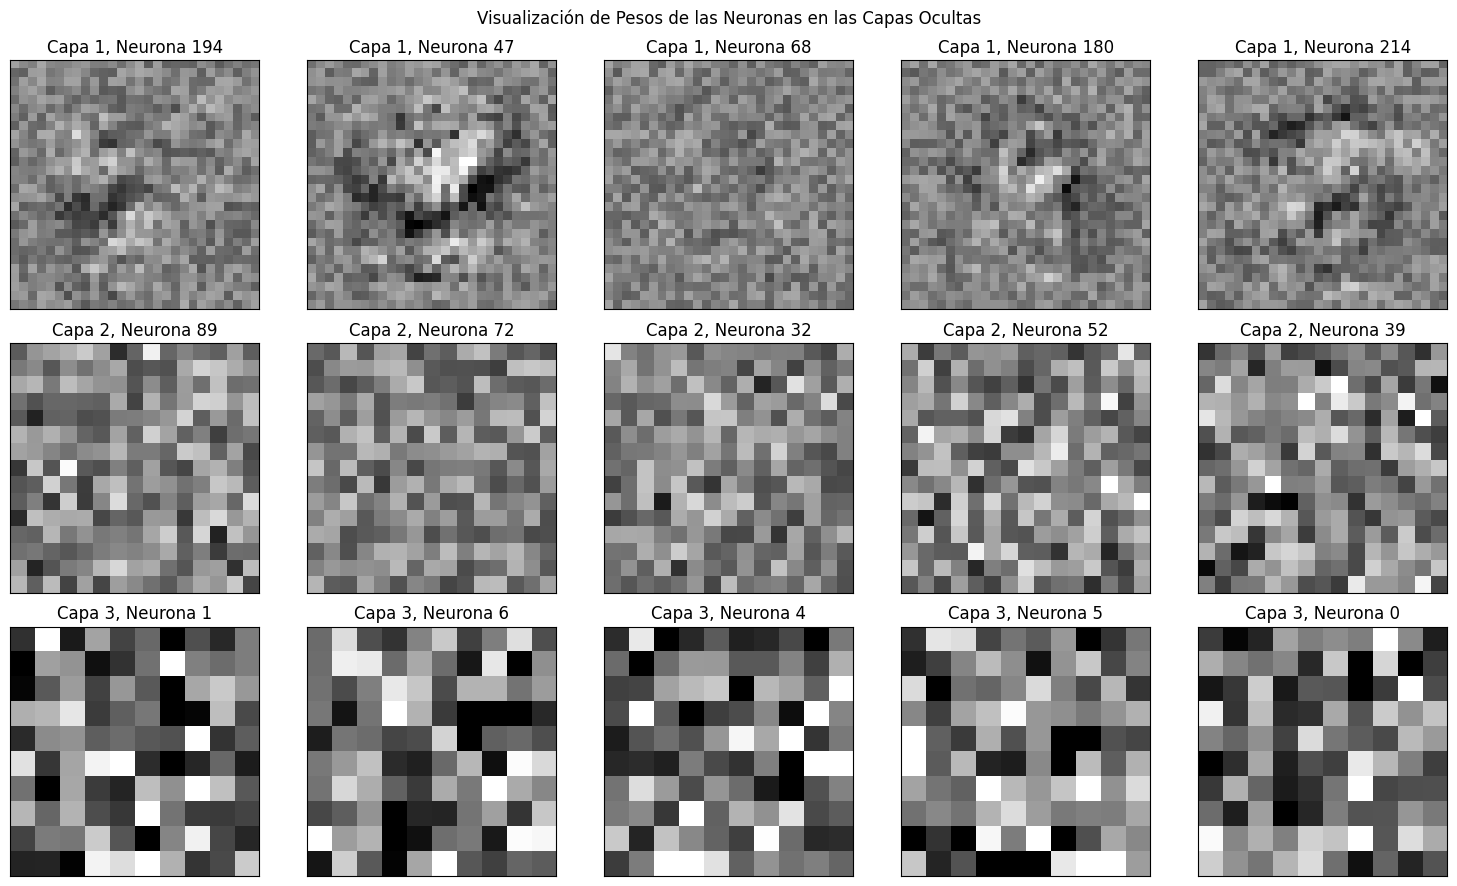

In [14]:
visualizacion_pesos_mlp(mlp)

### Tutoriales relacionados

* [Análisis de la variación del parametro de regularización alpha](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py)
* [Comparación de las diferentes estrategias de aprendizaje](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)
* [Accelaración de Sklearn (GPU) usando la extensión sklearnex](https://uxlfoundation.github.io/scikit-learn-intelex/2025.4/)
* [Accelaración de Sklearn (GPU) usando CuML](https://docs.rapids.ai/api/cuml/stable/cuml_intro/#where-possible-match-the-scikit-learn-api)

# MLP Clasificador multiclase en keras

* [Introducción a Keras 3](https://keras.io/getting_started/about/)
* [Tipos de framework en Keras 3](https://keras.io/api/models/)
  - [Modelo secuencal by Tensorflow](https://www.tensorflow.org/guide/keras/sequential_model)
  - [Modelo funcional by Tensorflow](https://www.tensorflow.org/guide/keras/functional_api)
  - [Modelo subclassing by Tensorflow](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing)
* [Tipos de funciones de pérdida](https://keras.io/api/losses/)

In [15]:
# Asumiendo que X_train y y_train ya están definidos como en el ejemplo anterior
# Preprocesar las etiquetas para que sean categóricas (one-hot encoding)
y_train_categorical = to_categorical(y_train)
y_train_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [16]:
# crear modelo usando el API secuencial
def MLPClassifier_keras():
    # Definir el modelo similar al de sklearn
    model = Sequential()
    model.add(Input(shape=(784,)))
    model.add(Dense(225, activation='relu'))  # Primera capa con 225 neuronas
    model.add(Dropout(0.3))  # Regularización con Dropout
    model.add(Dense(100, activation='relu'))  # Segunda capa con 100 neuronas
    model.add(Dropout(0.3))  # Regularización con Dropout
    model.add(Dense(10, activation='softmax'))  # Capa de salida para 10 clases

    return model

In [17]:
mlp_keras = MLPClassifier_keras()

In [18]:
# Compilar el modelo
mlp_keras.compile(loss='categorical_crossentropy',
            optimizer=SGD(),
            metrics=['accuracy'])

# Entrenar el modelo
history = mlp_keras.fit(X_train.values.astype(float), y_train_categorical,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3138 - loss: 2.0007 - val_accuracy: 0.7991 - val_loss: 0.9513
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6957 - loss: 1.0220 - val_accuracy: 0.8515 - val_loss: 0.5812
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7769 - loss: 0.7337 - val_accuracy: 0.8764 - val_loss: 0.4649
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8102 - loss: 0.6144 - val_accuracy: 0.8880 - val_loss: 0.4049
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8331 - loss: 0.5537 - val_accuracy: 0.8968 - val_loss: 0.3667
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8495 - loss: 0.4994 - val_accuracy: 0.9018 - val_loss: 0.3398
Epoch 7/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8636 - loss: 0.4648 - val_accuracy: 0.9084 - val_loss: 0.3175
Epoch 8/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8706 - loss: 0.4392 - val_accuracy: 0.

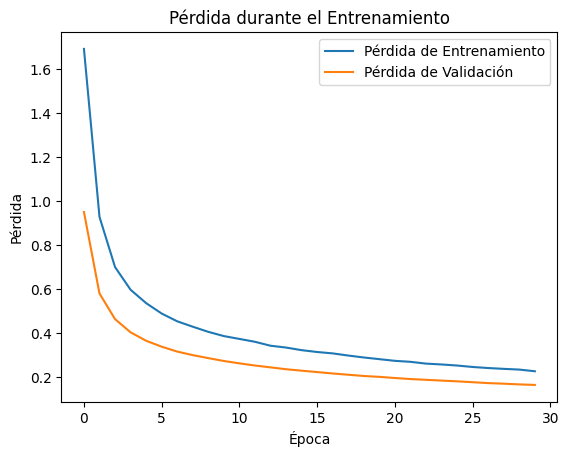

In [19]:
plot_loss_historia_keras(history)

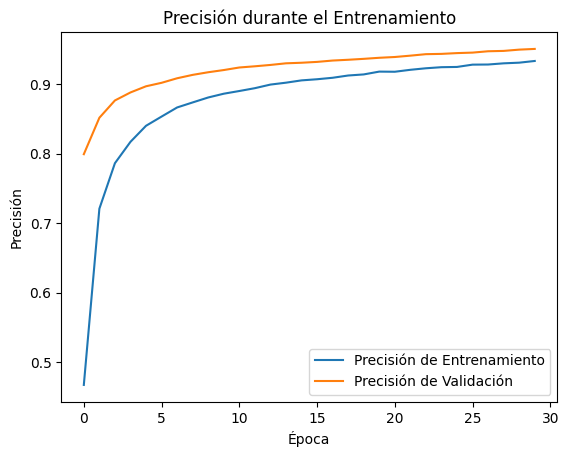

In [20]:
plot_acc_historia_keras(history)

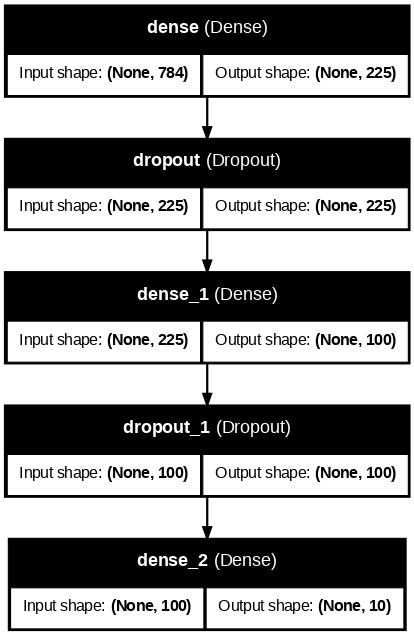

In [28]:
plot_model(mlp_keras, show_shapes=True, show_layer_names=True, dpi=80)

## Evaluación completa

In [21]:
y_test_categorical = to_categorical(y_test)

score = mlp_keras.evaluate(X_test.values.astype(float), y_test_categorical, batch_size=128)

score

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9484 - loss: 0.1750


[0.175654336810112, 0.9481428861618042]

In [22]:
# Realizar predicciones en el conjunto de prueba
y_pred = mlp_keras.predict(X_test.values.astype(float))

# Convertir las predicciones en etiquetas (la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.values.astype(int)  # Las etiquetas reales del conjunto de prueba

657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Reporte de Clasificación para el MLP en MNIST:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2058
           1       0.96      0.98      0.97      2364
           2       0.95      0.94      0.94      2133
           3       0.93      0.94      0.93      2176
           4       0.94      0.95      0.94      1936
           5       0.95      0.93      0.94      1915
           6       0.96      0.97      0.97      2088
           7       0.95      0.96      0.95      2248
           8       0.95      0.92      0.93      1992
           9       0.93      0.92      0.93      2090

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000



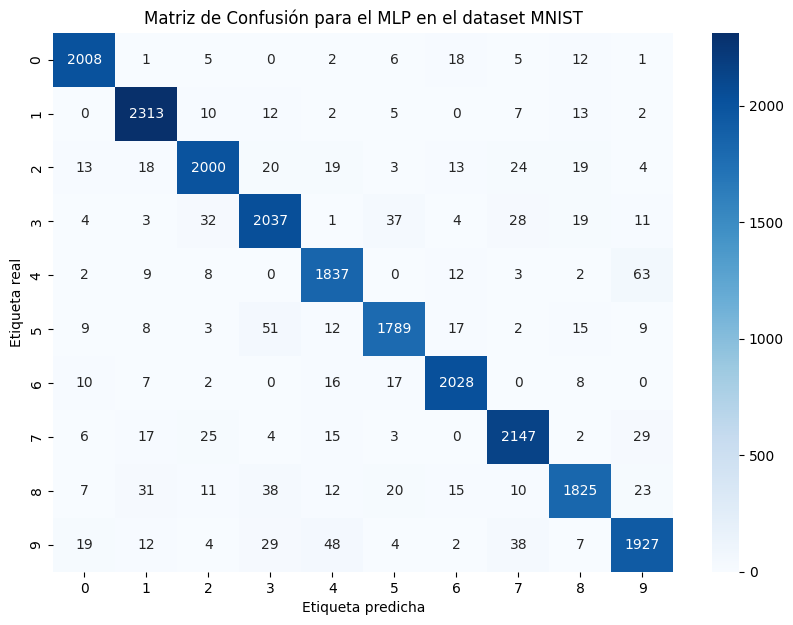

In [23]:
# Generar el reporte de clasificación
print("Reporte de Clasificación para el MLP en MNIST:\n")
print(classification_report(y_true, y_pred_classes))

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión usando Seaborn
plot_matriz_confusion(cm)

## Visualización de pesos

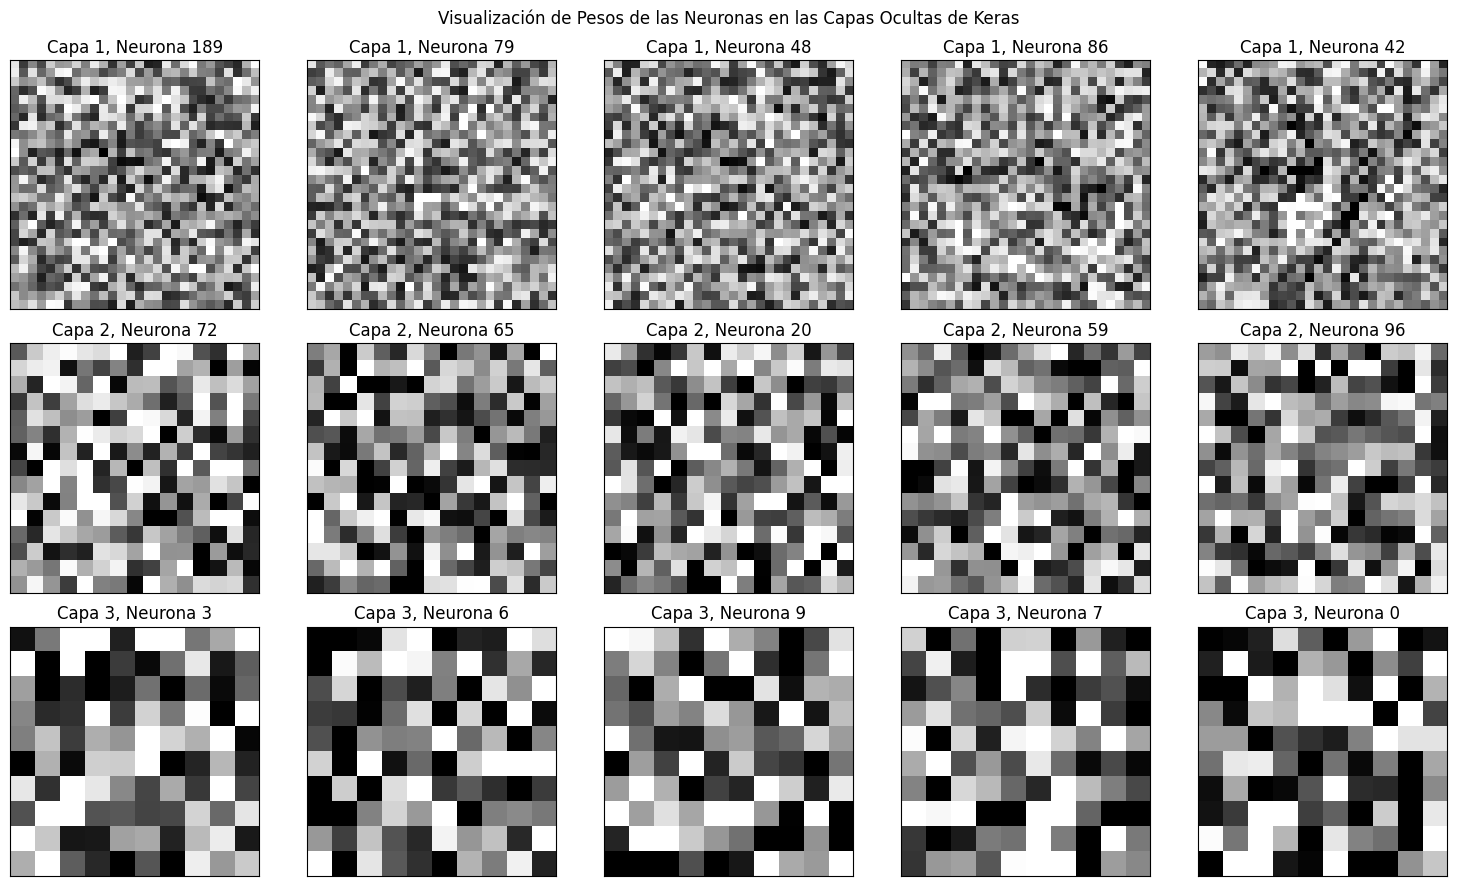

In [24]:
visualizacion_pesos_mlp_keras(mlp_keras)

### ✅ Cómo transformar tus datos para usar un MLP estándar (Keras o scikit-learn)

| Tipo de dato o problema         | ¿Qué debes hacer para usar un MLP?                                                                                                                                       | Ejemplo sencillo                                                                                  |
|--------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| 📝 Texto                   | Convertir el texto a vectores. Usa técnicas como **Bag of Words (BoW)**, **TF-IDF**.                              | Clasificación de sentimientos: convertir cada comentario en un vector TF-IDF                     |
| ⏱ Series temporales            | Dividir en **ventanas de tiempo fijas** y calcular **características estadísticas** (media, std, min, max, energía, etc.) por ventana.                              | Predicción de fallas: usar estadísticas de 10s de datos de sensores como entrada al MLP         |
| ❗ Anomalías                    | Etiquetar datos anómalos (si puedes).             | Detección de fraude: marcar transacciones normales y anómalas y entrenar un clasificador         |
| 🖼 Imágenes                    | Extraer **características manuales** (como color, textura, tamaño, etc.) o redimensionar las imágenes y vectorizarlas.         | Clasificación de imágenes de zapatos: usar un modelo CNN preentrenado para extraer features      |
| 🔊 Audio                       | Extraer **features de audio** como **MFCCs, espectrogramas, energía, pitch**, etc., y construir vectores con esas estadísticas.                                         | Detección de emociones en voz: usar MFCCs y energía para representar cada audio                  |



### 🧭 Guía paso a paso para construir tu baseline con un MLP

Sigue estos pasos para convertir tu idea o proyecto en un experimento funcional con un Perceptrón Multicapa (MLP), usando scikit-learn o Keras.

---

#### 1️⃣ Define el objetivo de predicción

- ¿Tu problema es de **clasificación** o **regresión**?
- ¿Cuál es la variable que quieres predecir?
- Ejemplos:
  - Clasificación: ¿Este artículo es de biología o matemáticas?
  - Regresión: ¿Cuál será el consumo energético el próximo mes?

---

#### 2️⃣ Identifica tu tipo de datos

- ¿Qué tipo de datos tienes?
  - Texto
  - Series temporales
  - Datos tabulares
  - Imágenes
  - Audio

🔍 Revisa la tabla anterior para ver cómo transformar tus datos para usarlos con un MLP.

---

#### 3️⃣ Preprocesa y vectoriza tus datos

- Normaliza tus valores si son numéricos (por ejemplo, entre 0 y 1).
- Si tienes texto, usa TF-IDF o BoW.
- Si tienes imágenes, vectorízalas (flatten).
- Si tienes secuencias, divide en ventanas y calcula estadísticas (media, std, etc.).

📌 Asegúrate de que **cada fila sea un ejemplo** y cada **columna una característica**.

---

#### 4️⃣ Define el tipo de salida y la función de pérdida

- **Clasificación binaria** → `sigmoid` + `binary_crossentropy`
- **Clasificación multiclase** → `softmax` + `categorical_crossentropy`
- **Regresión** → `linear` + `mean_squared_error` o `mean_absolute_error`

⚠️ Si usas `Keras`, recuerda convertir las etiquetas con `to_categorical()` si usas softmax.

---

#### 5️⃣ Construye tu MLP

- Decide cuántas capas ocultas y neuronas usar (ej. 2 capas de 128 y 64).
- Usa `relu` como activación oculta y `softmax` o `sigmoid` según el caso.
- Añade regularización (`Dropout`, `L2`) si hay riesgo de sobreajuste.
